# Policy Evaluation in Cliff Walking Environment - TD(0)

## The Cliff Walking Environment

The Cliff Walking environment is a gridworld with a discrete state space and discrete action space. The agent starts at grid cell S. The agent can move (deterministically) to the four neighboring cells by taking actions Up, Down, Left or Right. Trying to move out of the boundary results in staying in the same location. So, for example, trying to move left when at a cell on the leftmost column results in no movement at all and the agent remains in the same location. The agent receives -1 reward per step in most states, and -100 reward when falling off of the cliff. This is an episodic task; termination occurs when the agent reaches the goal grid cell G. Falling off of the cliff results in resetting to the start state, without termination.

The diagram below showcases the description above and also illustrates two of the policies we will be evaluating.

<img src="cliffwalk.png" style="height:400px">

In [21]:
%matplotlib inline
from rllib.rl_glue import RLGlue
from rllib.environment.cliff_walk_environment import CliffWalkEnvironment
from rllib.agent.td_agent import TDAgent
import numpy as np
from operator import add
from manager import Manager
from itertools import product
from tqdm import tqdm

## Environment
 
Given below is an annotated diagram of the environment with more details that may help in completing the tasks of this part of the assignment. Note that we will be creating a more general environment where the height and width positions can be variable but the start, goal and cliff grid cells have the same relative positions (bottom left, bottom right and the cells between the start and goal grid cells respectively).

<img src="cliffwalk-annotated.png" style="height:400px">

Once you have gone through the code and begun implementing solutions, it may be a good idea to come back here and see if you can convince yourself that the diagram above is an accurate representation of the code given and the code you have written.

In [22]:
### AUTOGRADER TESTS FOR STATE (5 POINTS)
# NOTE: The test below corresponds to the annotated diagram for the environment
#       given previously and is limited in scope. Hidden tests are used in the autograder.
#       You may wish to run other tests to check your implementation.
def test_state():
    env = CliffWalkEnvironment()
    env.env_init({"grid_height": 4, "grid_width": 12})
    coords_to_test = [(0, 0), (0, 11), (1, 5), (3, 0), (3, 9), (3, 11)]
    true_states = [0, 11, 17, 36, 45, 47]
    output_states = [env.state(coords) for coords in coords_to_test]
    assert(output_states == true_states)
test_state()

In [23]:
### AUTOGRADER TESTS FOR ACTION UP (5 POINTS)
# NOTE: The test below is again limited in scope. Hidden tests are used in the autograder.
#       You may wish to run other tests to check your implementation.
def test_action_up():
    env = CliffWalkEnvironment()
    env.env_init({"grid_height": 4, "grid_width": 12})
    env.agent_loc = (0, 0)
    env.env_step(0)
    assert(env.agent_loc == (0, 0))
    
    env.agent_loc = (1, 0)
    env.env_step(0)
    assert(env.agent_loc == (0, 0))
test_action_up()

In [24]:
### AUTOGRADER TESTS FOR REWARD & TERMINATION (10 POINTS)
# NOTE: The test below is limited in scope. Hidden tests are used in the autograder.
#       You may wish to run other tests to check your implementation.
def test_reward():
    env = CliffWalkEnvironment()
    env.env_init({"grid_height": 4, "grid_width": 12})
    env.agent_loc = (0, 0)
    reward_state_term = env.env_step(0)
    assert(reward_state_term[0] == -1 and reward_state_term[1] == env.state((0, 0)) and
           reward_state_term[2] == False)
    
    env.agent_loc = (3, 1)
    reward_state_term = env.env_step(2)
    assert(reward_state_term[0] == -100 and reward_state_term[1] == env.state((3, 0)) and
           reward_state_term[2] == False)
    
    env.agent_loc = (2, 11)
    reward_state_term = env.env_step(2)
    assert(reward_state_term[0] == -1 and reward_state_term[1] == env.state((3, 11)) and
           reward_state_term[2] == True)
test_reward()

In [25]:
### AUTOGRADER TESTS FOR TD-UPDATES (20 POINTS)
# NOTE: The test belows serve as a good check in debugging your code for the TD updates. However, 
#       as with the other tests, it is limited in scope. Hidden tests are used in the autograder.
#       You may wish to run other tests to check your implementation.
def test_td_updates():
    # The following test checks that the TD check works for a case where the transition 
    # garners reward -1 and does not lead to a terminal state. This is in a simple two state setting 
    # where there is only one action. The first state's current value estimate is 0 while the second is 1.
    # Note the discount and step size if you are debugging this test.
    agent = TDAgent()
    policy_list = np.array([[1.], [1.]])
    agent.agent_init({"policy": np.array(policy_list), "discount": 0.99, "step_size": 0.1})
    agent.values = np.array([0., 1.])
    agent.agent_start(0)
    reward = -1
    next_state = 1
    agent.agent_step(reward, next_state)
    assert(np.isclose(agent.values[0], -0.001) and np.isclose(agent.values[1], 1.))
    
    # The following test checks that the TD check works for a case where the transition 
    # garners reward -100 and lead to a terminal state. This is in a simple one state setting 
    # where there is only one action. The state's current value estimate is 0.
    # Note the discount and step size if you are debugging this test.
    agent = TDAgent()
    policy_list = np.array([[1.]])
    agent.agent_init({"policy": np.array(policy_list), "discount": 0.99, "step_size": 0.1})
    agent.values = np.array([0.])
    agent.agent_start(0)
    reward = -100
    next_state = 0
    agent.agent_end(reward)
    assert(np.isclose(agent.values[0], -10))
    
test_td_updates()

## Policy Evaluation Experiments

Finally, in this last part of the assignment, you will get to see the TD policy evaluation algorithm in action by looking at the estimated values, the per state value error and after the experiment is complete, the Mean Squared Value Error curve vs. episode number, summarizing how the value error changed over time.

The code below runs one run of an experiment given env_info and agent_info dictionaries. A "manager" object is created for visualizations and is used in part for the autograder. By default, the run will be for 5000 episodes. The true_values_file is specified to compare the learned value function with the values stored in the true_values_file. Plotting of the learned value  function occurs by default after every 100 episodes. In addition, when true_values_file is specified, the value error per state and the root mean square value error will also be plotted.

In [26]:
%matplotlib notebook

# Work Required: No. 
def run_experiment(env_info, agent_info, 
                   num_episodes=5000,
                   experiment_name=None,
                   plot_freq=100,
                   true_values_file=None,
                   value_error_threshold=1e-8):
    env = CliffWalkEnvironment
    agent = TDAgent
    rl_glue = RLGlue(env, agent)

    rl_glue.rl_init(agent_info, env_info)

    manager = Manager(env_info, agent_info, true_values_file=true_values_file, experiment_name=experiment_name)
    for episode in range(1, num_episodes + 1):
        rl_glue.rl_episode(0) # no step limit
        if episode % plot_freq == 0:
            values = rl_glue.agent.agent_message("get_values")
            manager.visualize(values, episode)

    values = rl_glue.agent.agent_message("get_values")
    if true_values_file is not None:
        # Grading: The Manager will check that the values computed using your TD agent match 
        # the true values (within some small allowance) across the states. In addition, it also
        # checks whether the root mean squared value error is close to 0.
        manager.run_tests(values, value_error_threshold)
    
    return values

The cell below just runs a policy evaluation experiment with the determinstic optimal policy that strides just above the cliff. You should observe that the per state value error and RMSVE curve asymptotically go towards 0. The arrows in the four directions denote the probabilities of taking each action. This experiment is ungraded but should serve as a good test for the later experiments. The true values file provided for this experiment may help with debugging as well.

<IPython.core.display.Javascript object>


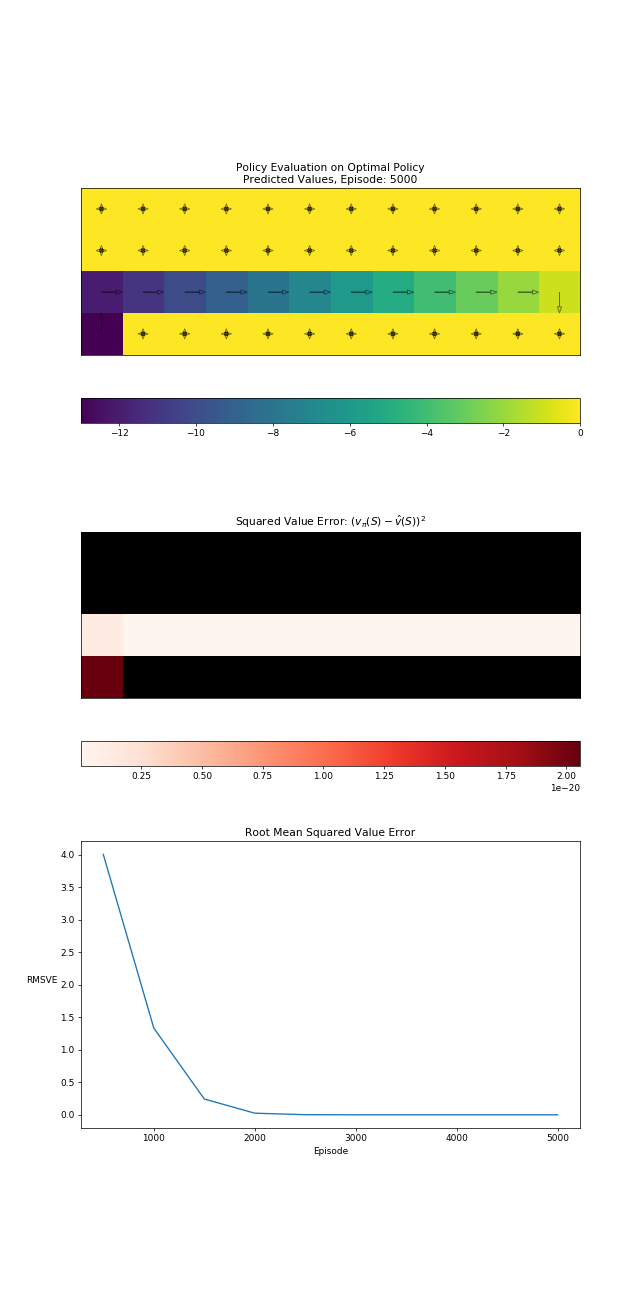

In [27]:
# Do not modify this cell!

env_info = {"grid_height": 4, "grid_width": 12, "seed": 0}
agent_info = {"discount": 1, "step_size": 0.01, "seed": 0}

# The Optimal Policy that strides just along the cliff
policy = np.ones(shape=(env_info['grid_width'] * env_info['grid_height'], 4)) * 0.25
policy[36] = [1, 0, 0, 0]
for i in range(24, 35):
    policy[i] = [0, 0, 0, 1]
policy[35] = [0, 0, 1, 0]

agent_info.update({"policy": policy})

true_values_file = "optimal_policy_value_fn.npy"
_ = run_experiment(env_info, agent_info, num_episodes=5000, experiment_name="Policy Evaluation on Optimal Policy",
                   plot_freq=500, true_values_file=true_values_file)

In [28]:
# The Safe Policy
# Hint: Fill in the dictionary below (as done in the previous cell) based on the safe policy illustration 
# in the environment diagram. This is the policy that strides as far as possible away from the cliff. 
# We call it a "safe" policy because if the environment has any stochasticity, this policy would do a good job in 
# keeping the agent from falling into the cliff (in contrast to the optimal policy shown before). 
# BOILERPLATE:
policy = np.ones(shape=(env_info['grid_width'] * env_info['grid_height'], 4)) * 0.25
### START CODE HERE ###
w = env_info['grid_width']
h = env_info['grid_height']

for i in range(w-1):
    policy[i] = [0,0,0,1]
    
for i in range(1,h):
    policy[w*i] = [1,0,0,0]
    policy[(w-1)+w*(i-1)] = [0,0,1,0]

### END CODE HERE ###

<IPython.core.display.Javascript object>


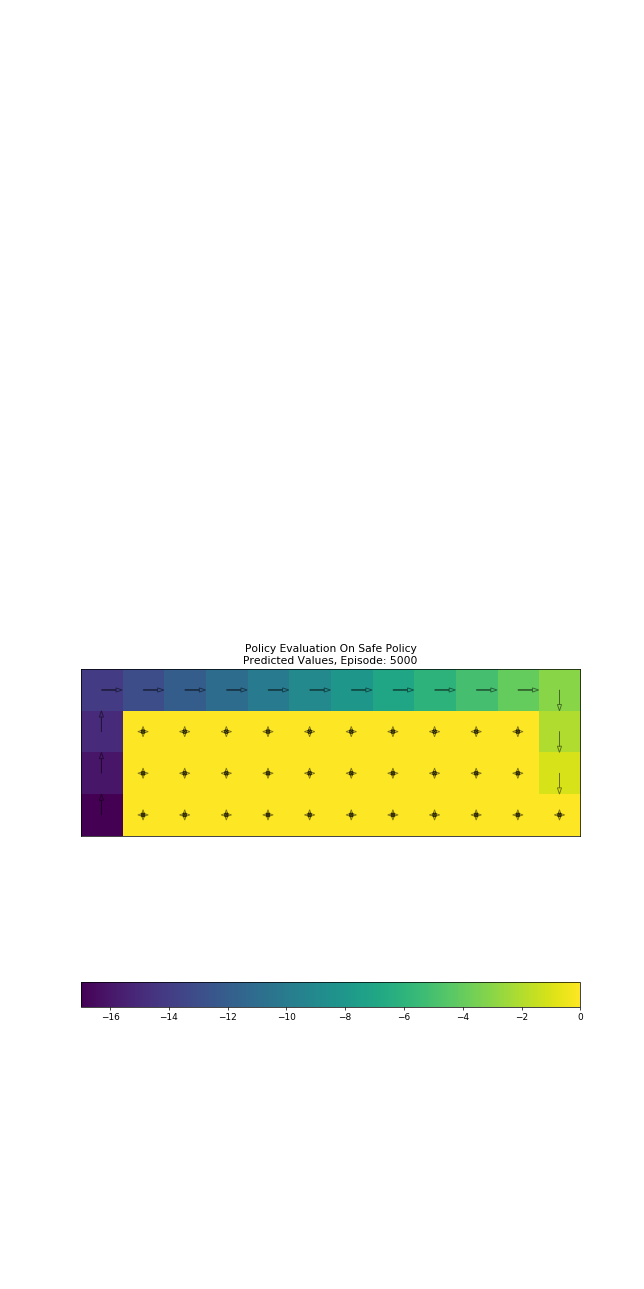

In [29]:
### AUTO-GRADER TESTS FOR POLICY EVALUATION WITH SAFE POLICY
agent_info.update({"policy": policy})
v = run_experiment(env_info, agent_info,
               experiment_name="Policy Evaluation On Safe Policy",
               num_episodes=5000, plot_freq=500)

In [30]:
# Do not modify this cell!

# A Near Optimal Stochastic Policy
# Now, we try a stochastic policy that deviates a little from the optimal policy seen above. 
# This means we can get different results due to randomness.
# We will thus average the value function estimates we get over multiple runs. 
# This can take some time, upto about 5 minutes from previous testing. 
# NOTE: The autograder will compare . Re-run this cell upon making any changes.

env_info = {"grid_height": 4, "grid_width": 12}
agent_info = {"discount": 1, "step_size": 0.01}

policy = np.ones(shape=(env_info['grid_width'] * env_info['grid_height'], 4)) * 0.25
policy[36] = [0.9, 0.1/3., 0.1/3., 0.1/3.]
for i in range(24, 35):
    policy[i] = [0.1/3., 0.1/3., 0.1/3., 0.9]
policy[35] = [0.1/3., 0.1/3., 0.9, 0.1/3.]
agent_info.update({"policy": policy})
agent_info.update({"step_size": 0.01})

In [31]:
### AUTO-GRADER TESTS FOR POLICY EVALUATION WITH NEAR OPTIMAL STOCHASTIC POLICY (40 POINTS)
arr = []
from tqdm import tqdm
for i in tqdm(range(30)):
    env_info['seed'] = i
    agent_info['seed'] = i
    v = run_experiment(env_info, agent_info,
                   experiment_name="Policy Evaluation On Optimal Policy",
                   num_episodes=5000, plot_freq=10000)
    arr.append(v)
average_v = np.array(arr).mean(axis=0)

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [03:05<00:00,  6.17s/it]


In [32]:
average_v

array([-35.1101799 , -34.14430962, -32.25996728, -29.928567  ,
       -27.25729681, -24.38646056, -21.54122257, -18.555649  ,
       -15.50277454, -12.58455332, -10.17809861,  -8.6067797 ,
       -44.33911429, -43.34335361, -40.59186991, -37.70475694,
       -33.94707742, -30.08154392, -26.22608224, -22.36787048,
       -18.25379971, -14.06766684, -10.18618315,  -7.1868852 ,
       -59.42240118, -58.89121519, -54.64117486, -49.64186684,
       -43.9483098 , -38.80935429, -33.72949945, -28.13619841,
       -21.83704279, -15.33388523,  -8.41128797,  -1.58324294,
       -63.66111799,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ])

## Wrapping Up
Congratulations, you have completed assignment 2! In this assignment, we investigated a very useful concept for sample-based online learning: temporal difference. We particularly looked at the prediction problem where the goal is to find the value function corresponding to a given policy. In the next assignment, by learning the action-value function instead of the state-value function, you will get to see how temporal difference learning can be used in control as well.